# Data Ingestion – Tabular Formats

_Tidy datasets are all alike, but every messy dataset is messy in its own way._

Hadley Wickham (cf. Leo Tolstoy)

A great deal of data both does and should live in tabular formats; to put it flatly, this means formats that have rows and columns.  In a theoretical sense, it is possible to represent *every* collection of *structured data* in terms of multiple "flat" or "tabular" collections if we also have a concept of *relations*.  Relational database management systems (RDBMS) have had a great deal of success since 1970, and a very large part of all the world's data lives in RDBMS's.  Another large share lives in formats that are not relational as such, but that are nonetheless tabular, wherein relationships may be *imputed* in an ad hoc, but uncumbersome, way.

As the Preface mentioned, the data ingestion chapters will concern themselves chiefly with structural or mechanical problems that make data dirty.  Later in the book we will focus more on content or numerical issues in data.

This chapter discusses tabular formats including CSV, spreadsheets, SQL databases, and scientific array storage formats.  The last sections look at some general concepts around data frames, which will typically be how data scientists manipulate tabular data. Much of this chapter is concerned with the actual mechanics of ingesting and working with a variety of data formats, using several different tools and programming languages. The Preface discusses why I wish to remain language agnostic—or multilingual—in my choices.  Where each format is prone to particular kinds of data integrity problems, special attention is drawn to that.  Actually *remediating* those characteristic problems is largely left until later chapters; detecting them is the focus of our attention here.

As _The Hitchhiker's Guide to the Galaxy_ is humorously inscribed: "Don't Panic!" We will explain in much more detail the concepts mentioned here.

---

We run the setup code that will be standard throughout this book.  As the Preface mentions, each chapter can be run in full, assuming available configuration files have been utilized.  The prompts you see throughout this book, such as `In [1]:` and `Out[4]` are those used by Jupyter notebooks.  Although it is not usually best practice in Python to use `import *`, we do so here to bring in many names without a long block of imports.

In [1]:
from src.setup import *

With our various Python libraries now available, let us utilize them to start cleaning data.

## Tidying Up

**Concepts**: 

* Tidyness and database normalization
* Rows versus columns
* Labels versus values

Hadley Wickham and Garrett Grolemund, in their excellent and freely available book, <u>[R for Data Science](https://r4ds.had.co.nz/)</u>, promote the concept of "tidy data." The Tidyverse collection of R packages attempt to realize this concept in concrete libraries.  Wickham and Grolemund's idea of tidy data has a very close intellectual forebearer in the concept of database normalization, which is a large topic addressed in depth neither by them nor in this current book.  The canonical reference on database normalization is C. J. Date's <u>An Introduction to Database Systems</u> (Addison Wesley; 1975 and numerous subsequent editions).

In brief, tidy data carefully separates variables (the columns of a table; also called features or fields) from observations (the rows of a table; also called samples).  At the intersection of these two, we find values, one data item (datum) in each cell.  Unfortunately, the data we encounter is often not arranged in this useful way, and it requires *normalization*.  In particular, what are really values are often represented either as columns or as rows instead. To demonstrate what this means, let us consider an example.

Returning to the small elementary school class we presented in the Preface, we might encounter data looking like this:

In [45]:
students = pl.read_csv("data/students-scores.csv")
students

Last Name,First Name,4th Grade,5th Grade,6th Grade
str,str,str,str,str
"""Johnson""","""Mia""","""A""","""B+""","""A-"""
"""Lopez""","""Liam""","""B""","""B""","""A+"""
"""Lee""","""Isabella""","""C""","""C-""","""B-"""
"""Fisher""","""Mason""","""B""","""B-""","""C+"""
"""Gupta""","""Olivia""","""B""","""A+""","""A"""
"""Robinson""","""Sophia""","""A+""","""B-""","""A"""


This view of the data is easy for humans to read.  We can see trends in the scores each student received over several years of education.  Moreover, this format might lend itself to useful visualizations fairly easily.

This next cell uses a "fluent" programming style that may look unfamiliar to some Python programmers.  I discuss this style in the section below on data frames.  The fluent style is used in many data science tools and languages. For example, this is typical Pandas code that plots the students' scores by year.

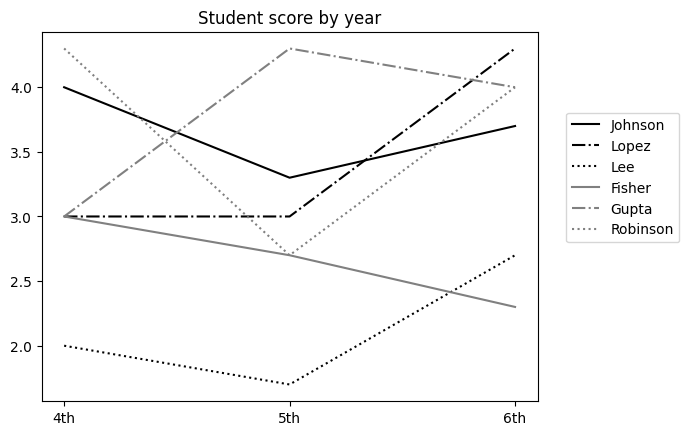

In [131]:
to_num = {'A+': 4.3, 'A': 4, 'A-': 3.7,
          'B+': 3.3, 'B': 3, 'B-': 2.7,
          'C+': 2.3, 'C': 2, 'C-': 1.7}
df = (students.with_columns(
    pl.col("4th Grade").replace(to_num, default=None),
    pl.col("5th Grade").replace(to_num, default=None),
    pl.col("6th Grade").replace(to_num, default=None)
)
    .drop(["First Name", "Last Name"])
    .transpose(include_header=False,
               column_names=students["Last Name"])
)
classes = ["4th", "5th", "6th"]
for student in students["Last Name"]:
    plt.plot(classes, df[student], label=student)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, .80));
plt.title("Student score by year");

This data layout exposes its limitations once the class advances to 7th grade, or if we were to obtain 3rd grade information.  To accommodate such additional data, we would need to change the number and position of columns, not simply add additional rows.  It is natural to make new observations or identify new samples (rows), but usually awkward to change the underlying variables (columns).

The particular class level (e.g. 4th grade) that a letter grade pertains to is, at heart, a value not a variable.  Another way to think of this is in terms of independent variables versus dependent variables.  Or in machine learning terms, features versus target.  In some way, the class level might correlate with or influence the resulting letter grade; perhaps the teachers at the different levels have different biases, or children of a certain age lose or gain interest in schoolwork, for example.

For most analytic purposes, this data would be more useful if we make it tidy (normalized) before further processing.  In Pandas, the `DataFrame.melt()` method can perform this tidying.  We pin some of the columns as `id_vars`, and we set a name for the combined columns as a variable and the letter grade as a single new column.  This Pandas method is slightly magical, and takes some practice to get used to.  The key thing is that it preserves data, simply moving it between column labels and data values.

In [5]:
students.melt(
    id_vars=["Last Name", "First Name"], 
    var_name="Level",
    value_name="Score"
).set_index(['First Name', 'Last Name', 'Level'])

,,,Score
First Name,Last Name,Level,
Mia,Johnson,4th Grade,A
Liam,Lopez,4th Grade,B
Isabella,Lee,4th Grade,C
Mason,Fisher,4th Grade,B
...,...,...,...
Isabella,Lee,6th Grade,B-
Mason,Fisher,6th Grade,C+
Olivia,Gupta,6th Grade,A
Sophia,Robinson,6th Grade,A


Having looked at the idea of tidyness as a general goal for tabular, let us being looking at specific data formats, beginning with comma-separated values and fixed-width files.

## CSV

> Speech sounds cannot be understood, delimited, classified and explained
> except in the light of the tasks which they perform in language.<br/>
> –Roman Jakobson

**Concepts**:

* Delimited and fixed-width data
* Parsing problems
* Heuristics and "eyeballing"
* Inferring data types
* Escaping special characters
* Families of related CSV files

Delimited text files, especially comma-separated values (CSV) files, are ubiquitous.  These are text files that put multiple values on each line, and separate those values with some semi-reserved character, such as a comma.  They are almost always the exchange format used to transport data between other tabular representations, but a great deal of data both starts and ends life as CSV, perhaps never passing through other formats.  

Reading delimited files is not the fastest way of reading data from disk into RAM memory, but it is also not the slowest.  Of course, that concern only matters for large-ish data sets, not for the small data sets that make up most of our work as data scientists (small nowadays means roughly "fewer then 100k rows").

There are a great number of deficits in CSV files, but also some notable strengths.  CSV files are the format second most susceptible to structural problems.  All formats are generally equally prone to content problems, which are not tied to the format itself.  Spreadsheets like Excel are, of course, *by a very large margin* the worst format for every kind of data integrity concern.

At the same time, delimited formats—or fixed-width text formats—are also almost the only ones you can easily open and make sense of in a text editor or easily manipulate using command-line tools for text processing.  Thereby delimited files are pretty much the only ones you can fix fully manually without specialized readers and libraries.  Of course, formats that rigorously enforce structural constraints *do avoid some* of the need to do this.  Later in this chapter, and in the next two chapters, a number of formats that enforce structure more are discussed.

One issue that you could encounter in reading CSV or other textual files is the actual character set encoding may not be the one you expect, or that is the default on your current system.  In this age of Unicode, this concern is diminishing, but only slowly, and archival files continue to exist.  This topic is discussed in chapter 3 (*Data Ingestion – Repurposing Data Sources*) in the section *Custom Text Formats*.

### Sanity Checks

As a quick example, suppose you have just received a medium sized CSV file, and you want to make a quick sanity check on it. At this stage, we are concerned about whether the file is formatted correctly at all.  We can do this with command-line tools, even if most libraries are likely to choke on them (such as shown in the next code cell).  Of course, we could also use Python, R, or another general-purpose language if we just consider the lines as text initially.

In [6]:
# Use try/except to avoid full traceback in example
try:
    pd.read_csv('data/big-random.csv')
except Exception as err:
    print_err(err)

ParserError
Error tokenizing data. C error: Expected 6 fields in line 75, saw 8


What went wrong there? Let us check.

In [1]:
%%bash
# What is the general size/shape of this file?
wc data/big-random.csv

 100000  100000 4335846 data/big-random.csv


Great! 100,000 rows; but there is some sort of problem on line 75 according to Pandas (and perhaps on other lines as well).  Using a single piped bash command which counts commas per line might provide insight.  We could absolutely perform this same analysis in Python, R, or other languages; however, being familiar with command-line tools is a benefit to data scientists in performing one-off analyses like this.

In [8]:
%%bash
cat data/big-random.csv | 
    tr -d -c ',\n' | 
    awk '{ print length; }' | 
    sort | 
    uniq -c

     46 3
  99909 5
     45 7


So we have figured out already that 99,909 of the lines have the expected 5 commas.  But 46 have a deficit and 45 a surplus.  Perhaps we will simply discard the bad lines, but that is not altogether too many to consider fixing by hand, even in a text editor.  We need to make a judgement, on a per problem basis, about both the relative effort and reliability of automation of fixes versus manual approaches.  Let us take a look at a few of the problem rows.

In [9]:
%%bash
grep -C1 -nP '^([^,]+,){7}' data/big-random.csv | head

74-squarcerai,45,quiescenze,12,scuoieremo,70
75:fantasmagorici,28,immischiavate,44,schiavizzammo,97,sfilzarono,49
76-interagiste,50,repentagli,72,attendato,95
--
712-resettando,58,strisciato,46,insaldai,62
713:aspirasse,15,imbozzimatrici,70,incanalante,93,succhieremo,41
714-saccarometriche,18,stremaste,12,hindi,19
--
8096-squincio,16,biascicona,93,solisti,70
8097:rinegoziante,50,circoncidiamo,83,stringavate,79,stipularono,34


Looking at these lists of Italian words and integers of slightly varying number of fields does not immediately illuminate the nature of the problem.  We likely need more domain or problem knowledge.  However, given that fewer than 1% of rows are a problem, perhaps we should simply discard them for now.  If you do decide to make a modification such as removing rows, then versioning the data, with accompanying documentation of change history and reasons, becomes crucial to good data and process provenance.

This next cell uses a regular expression to filter the lines in the "almost CSV" file.  The pattern may appear confusing, but regular expressions provide a compact way of describing patterns in text.  The match in `pat` indicates that from beginning of a line (`^`) until the end of that line (`$`) there are exactly five repetitions of character sequences that do not include commas, each followed by one comma (`[^,]+,`).

In [10]:
import re
pat = re.compile(r'^([^,]+,){5}[^,]*$')
with open('data/big-random.csv') as fh:
    lines = [l.strip().split(',') 
             for l in fh if re.match(pat, l)]
pd.DataFrame(lines)

,0,1,2,3,4,5
0,infilaste,21,esemplava,15,stabaccavo,73
1,abbadaste,50,enartrosi,85,iella,54
2,frustulo,77,temporale,83,scoppianti,91
3,gavocciolo,84,postelegrafiche,93,inglesizzanti,63
...,...,...,...,...,...,...
99905,notareschi,60,paganico,64,esecutavamo,20
99906,rispranghiamo,11,schioccano,44,imbozzarono,80
99907,compone,85,disfronderebbe,19,vaporizzavo,54
99908,ritardata,29,scordare,43,appuntirebbe,24


In the code we managed, within Python, to read all rows without formatting problems.  We could also have used the `pd.read_csv()` parameter `error_bad_lines=False` to achieve the same effect, but walking through it in plain Python and Bash gives you a better picture of why they are excluded.

### The Good, The Bad, and The Textual Data

Let us return to some virtues and deficits of CSV files.  Here when we mention CSV, we really mean any kind of delimited file.  And specifically, text files that store tabular data nearly always use a single character for a delimiter, and end rows/records with a newline (or carriage return and newline in legacy formats).  Other than commas, probably the most common delimiters you will encounter are tabs and the pipe character `|`.  However, nearly all tools are more than happy to use an arbitrary character.

Fixed-width files are similar to delimited ones.  Technically they are different in that, although they are line oriented, they put each field of data in specific character positions within each line.  An example is used in the next code cell below.  Decades ago, when Fortran and Cobol were more popular, fixed-width formats were more prevalent; my perception is that their use has diminished in favor of delimited files.  In any case, fixed-width textual data files have most of the same pitfalls and strengths as do delimited ones.

**The Bad**

Columns in delimited or flat files do not carry a data type, being simply text values.  Many tools will (optionally) make guesses about the data type, but these are subject to pitfalls.  Moreover, even where the tools accurately guess the broad type category (i.e. string vs. integer vs. real number) they cannot guess the specific bit length desired, where that matters.

Likewise, the representation used for "real" numbers is not encoded—most systems deal with IEEE-754 floating-point numbers of some length, but occasionally decimals of some specific length are more appropriate for a purpose.

The most typical way that type inference goes wrong is where the initial records in some data set have an apparent pattern, but later records deviate from this.  The software library may infer one data type but later encounter strings that cannot be cast as such.  "Earlier" and "later" here can have several different meanings.  

For out-of-core data frame libraries like **Vaex** and **Dask** (Python libraries) that read *lazily*, type heuristics might be applied to a first few records (and perhaps some other sampling) but will not see those strings that do not follow the assumed pattern.  However, later might also mean months later, when new data arrives.<sup><i>partnum</i></sup>

<div id="partnum"
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>partnum</i><br/>
For example, in a former job of mine, we received client data about commercial products that had a "part number."  That number was an actual integer, for many months, until it was not; it became a string that sometimes mixed letters with numerals. Unfortunately, other tooling had already made a wrong assumption about the undocumented data type (in this case an SQL schema, but it could be other code as well).
</div>

Most data frame libraries are greedy about inferring data types—although all will allow manual specification to shortcut inference.

For many layouts, data frame libraries can guess a fixed-width format and infer column positions and data types (where it cannot guess, we could manually specify).  But the guesses about data types can go wrong.  For example, viewing the raw text, we see a fixed-width layout in `parts.fwf`.

In [11]:
%%bash
cat data/parts.fwf

Part_No  Description              Maker               Price (USD)
12345    Wankle rotary engine     Acme Corporation    555.55
67890    Sousaphone               Marching Inc.       333.33
2468     Feather Duster           Sweeps Bros         22.22
A9922    Area 51 metal fragment   No Such Agency      9999.99

Reading in a few rows of data:

Reading this with Pandas correctly infers the intended column positions for the fields.

In [12]:
df = pd.read_fwf('data/parts.fwf', nrows=3)
df

,Part_No,Description,Maker,Price (USD)
0,12345,Wankle rotary engine,Acme Corporation,555.55
1,67890,Sousaphone,Marching Inc.,333.33
2,2468,Feather Duster,Sweeps Bros,22.22


In [13]:
df.dtypes

Part_No          int64
Description     object
Maker           object
Price (USD)    float64
dtype: object

We deliberately only read the start of the `parts.fwf` file.  From those first few rows, Pandas made a type inference of `int64` for the `Part_No` column.

Let us read the entire file.  Pandas does the "right thing" here: `Part_No` becomes a generic object, i.e. string. However, if we had a million rows instead, and the heuristics Pandas uses, for speed and memory efficiency, happened to limit inference to the first 100,000 rows, we might not be so lucky.

In [14]:
df = pd.read_fwf('data/parts.fwf')
df

,Part_No,Description,Maker,Price (USD)
0,12345,Wankle rotary engine,Acme Corporation,555.55
1,67890,Sousaphone,Marching Inc.,333.33
2,2468,Feather Duster,Sweeps Bros,22.22
3,A9922,Area 51 metal fragment,No Such Agency,9999.99


In [15]:
df.dtypes  # type of `Part_No` changed

Part_No         object
Description     object
Maker           object
Price (USD)    float64
dtype: object

---

Delimited files—but not so much fixed-width files—are prone to escaping issues.  In particular, CSVs specifically often contain descriptive fields that sometimes contain commas within the value itself.  When done right, this comma should be escaped.  It is often not done right in practice.

CSV is actually a family of different dialects, mostly varying in their escaping conventions.  Sometimes spacing before or after commas is treated differently across dialects as well. One approach to escaping is to put quotes around either every string value, or every value of any kind, or perhaps only those values that contain the prohibited comma.  This varies by tool and by the version of the tool.  Of course, if you quote fields, there is potentially a need to escape those quotes; usually this is done by placing a backslash before the quote character when it is part of the value.  

An alternate approach is to place a backslash before those commas that are not intended as a delimeter but rather part of a string value (or numeric value that might be formatted, e.g. `$1,234.56`).  Guessing the variant can be a mess, and even single files are not necessarily self consistent between rows, in practice (often different tools or versions of tools have touched the data).

Tab-separated and pipe-separated formats are often chosen with the hope of avoiding escaping issues.  This works to an extent.  Both tabs and pipe symbols are far less common in ordinary prose.  But both still wind up occurring in text occasionally, and all the escaping issues come back.  Moreover, in the face of escaping, the simplest tools sometimes fail.  For example, the bash command `cut -d,` will not work in these cases, nor will Python's `str.split(',')`.  A more custom parser becomes necessary, albeit a simple one compared to full-fledged grammars.  Python's standard library `csv` module is one such custom parser.

The corresponding danger for fixed-width files, in contrast to delimited ones, is that values become too long.  Within a certain line position range you can have any codepoints whatsoever (other than newlines).  But once the description or name that someone thought would never be longer than, say, 20 characters becomes 21 characters, the format fails.

---

A special consideration arises around reading datetime formats.  Data frame libraries that read datetime values typically have an optional switch to parse certain columns as datetime formats.  Libraries such as Pandas support heuristic guessing of datetime formats; the problem here is that applying a heuristic to each of millions of rows can be *exceedingly slow*.  Where a date format is uniform, using a manual format specifier can make it several orders of magnitude faster to read.  Of course, where the format varies, heuristics are practically magic; and perhaps we should simply marvel that the dog can talk at all rather than criticize its grammar. Let us look at a Pandas' attempt to guess datetimes for each row of a tab-separated file.

In [16]:
%%bash
# Notice many date formats
cat data/parts.tsv

Part_No	Description	Date	Price (USD)
12345	Wankle rotary	2020-04-12T15:53:21	555.55
67890	Sousaphone	April 12, 2020	333.33
2468	Feather Duster	4/12/2020	22.22
A9922	Area 51 metal	04/12/20	9999.99


In [17]:
# Let Pandas make guesses for each row
# VERY SLOW for large tables
parts = pd.read_csv('data/parts.tsv', 
                    sep='\t', parse_dates=['Date'])
parts

,Part_No,Description,Date,Price (USD)
0,12345,Wankle rotary,2020-04-12T15:53:21,555.55
1,67890,Sousaphone,"April 12, 2020",333.33
2,2468,Feather Duster,4/12/2020,22.22
3,A9922,Area 51 metal,04/12/20,9999.99


We can verify that the dates are genuinely a datetime data type within the DataFrame.

In [18]:
parts.dtypes

Part_No         object
Description     object
Date            object
Price (USD)    float64
dtype: object

We have looked at some challenges and limitations of delimited and fixed-width formats, let us consider their considerable advantages as well.

**The Good**

The biggest strength of CSV files, and their delimited or fixed-width cousins, is the ubiquity of tools to read and write them.  Every library dealing with data frames or arrays, across every programming language, knows how to handle them.  Most of the time the libraries parse the quirky cases pretty well.  Every spreadsheet program imports and exports as CSV.  Every RDBMS—and most non-relational databases as well—imports and exports as CSV.  Most programmers' text editors even have facilities to make editing CSV easier.  Python has a standard library module `csv` that processes many dialects of CSV (or other delimited formats) as a line-by-line record reader.

The fact that so very many structurally flawed CSV files live in the wild shows that not *every* tool handles them entirely correctly.  In part, that is probably because the format is simple enough to *almost* work without custom tools at all. I have myself, in a "throw-away script," written `print(",".join([1,2,3,4]), file=csv)` countless times; that works well, until it doesn't.  Of course, throw-away scripts become fixed standard procedures for data flow far too often.

---

The lack of type specification is often a strength rather than a weakness.  For example, the part numbers mentioned a few pages ago may have started out always being integers as an actual business intention, but later on a need arose to use non-integer "numbers."  With formats that have a formal type specifier, we generally have to perform a migration and copy to move old data into a new format that follows the loosened or revised constraints.

One particular case where a data type change happens especially often, in my experience, is with finite-width character fields.  Initially some field is specified as needing 5, or 15, or 100 characters for its maximum length, but then a need for a longer string is encountered later, and a fixed table structure or SQL database needs to be modified to accommodate the longer length.  Even more often—especially with databases—the requirement is underdocumented, and we wind up with a data set filled with truncated strings that are of little utility (and perhaps permanently lost data).

Text formats in general are usually flexible in this regard. Delimited files—but not fixed-width files—will happily contain fields of arbitrary length.  This is similarly true of JSON data, YAML data<sup><i>config</i></sup>, XML data, log files, and some other formats that simply utilize text, often with line-oriented records.  In all of this, data typing is very loose and only genuinely exists in the data processing steps.  That is often a great virtue.

<div id="config"
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>config</i><br/>
YAML usually contains relatively short configuration information rather than *data* in the prototypic sense.  TOML is a similar format in this regard, as is the older INI format.  All of these are really intended for hand editing, and hence are usually of small size, even though good APIs for reading and writing their data are common.  While you <i>could</i> put a million records into any of these formats, you will rarely or never encounter that in practice.
</div>

---

A related "looseness" of CSV and similar formats is that we often indefinitely aggregate multiple CSV files that follow the same informal schema.  Writing a different CSV file for each day, or each hour, or each month, of some ongoing data collection is very commonplace.  Many tools, such as Dask and Spark will seamlessly treat collections of CSV files (matching a *glob* pattern on the file system) as a single data set.  Of course, in tools that do not directly support this, manual concatenation is still not difficult.  But under the model of having a directory that contains an indefinite number of related CSV snapshots, presenting it as a single common object is helpful.

The libraries that handle families of CSV files seamlessly are generally lazy and distributed.  That is, with these tools, you do not typically read in all the CSV files at once, or at least not into the main memory of a single machine.  Rather, various cores or various nodes in a cluster will each obtain file handles to individual files, and the schema information will be inferred from only one or a few of the files, with actual processing deferred until a specific (parallel) computation is launched.  Splitting processing of an individual CSV file across cores is not easily tractable since a reader can only determine where a new record begins by scanning until it finds a newline.

While details of the specific APIs of libraries for distributed data frames is outside the scope of this book, the fact that parallelism is easily possible given an initial division of data into many files is a significant strength for CSV as a format.  Dask in particular works by creating many Pandas DataFrames and coordinating computation upon all of them (or those needed for a given result) with an API that exactly copies the same methods of individual Pandas objects.

We read this family of CSV files into one virtualized DataFrame that acts like a Pandas DataFrame, even if loading it with Pandas would require more memory than our local system allows.  In this specific example, the collection of CSV files is not genuinely too large for a modern workstation to read into memory; but when it becomes so, using some distributed or out-of-core system like Dask is necessary to proceed at all.

Having looked at some pros and cons of working with CSV data, let us turn to another format where a great deal of data is stored.  Unfortunately, for spreadsheets, there are almost exclusively cons.

## Spreadsheets Considered Harmful

> Drugs are bad. m'kay. You shouldn't do drugs. m'kay. 
> If you do them you're bad, because drugs are bad. m'kay. 
> It's a bad thing to do drugs, so don't be bad by doing drugs. m'kay.<br/>
> –Mr. Mackay (South Park)

**Concepts**:

* Non-enforced field/column identity
* Computational opacity
* Semi-tabular data
* Non-contiguous data
* Invisible data and data type discrepancies
* User interface as attractive nuisance

Edward Tufte, that brilliant doyen of information visualization, wrote an essay called *[The Cognitive Style of Powerpoint: Pitching Out Corrupts Within](https://www.edwardtufte.com/tufte/powerpoint)*.  Amongst his observations is that the manner in which slide presentations, and Powerpoint specifically, hides important information more than it reveals it, was a major or even main cause of the 2003 Columbia space shuttle disaster.  Powerpoint is anathema to clear presentation of information.

To no less of a degree, spreadsheets in general, and Excel in particular, are anathema to effective data science.  While perhaps not as much as in CSV files, a great share of the world's data lives in Excel spreadsheets.  There are numerous kinds of data corruption that are the special realm of spreadsheets.  As a bonus, data science tools read spreadsheets much more slowly than they do every other format, while spreadsheets also have hard limits on the amount of data they can contain that other formats do not impose.

Most of what spreadsheets do to make themselves convenient for their users makes them bad for scientfic reproducibility, data science, statistics, data analysis, and related areas.<sup><i>computation</i></sup> Spreadsheets have apparent rows and columns in them, but nothing enforces consistent use of those, even within a single sheet.  Some particular feature often lives in column F for some rows, but the equivalent thing is in column H for other rows, for example.  Contrast this with a CSV file or an SQL table; for these latter formats, while all the data in a column is not necessarily *good* data, it generally must pertain to the same feature.

<div id="computation"
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>computation</i><br/>
Another danger of spreadsheets is not around data ingestion, per se, at all. Computation within spreadsheets is spread among many cells in no obvious or easily inspectable order, leading to numerous large-scale disasterous consequences (loss of <a href="https://www.businessinsider.com/excel-partly-to-blame-for-trading-loss-2013-2">billions in financial transaction</a>; a <a href="https://theconversation.com/the-reinhart-rogoff-error-or-how-not-to-excel-at-economics-13646">worldwide economic planning debacle</a>; a <a href="https://www.bbc.com/news/technology-54423988">massive failure of Covid-19 contact tracing</a> in the UK).  The <a href="http://www.eusprig.org/">European Spreadsheet Risks Interest Group</a> is an entire organization devoted to chronicling such errors.  They present a number of lovely quotes, including this one:
    
> There is a literature on denial, which focuses on illness and the fact that many people with terminal illnesses deny the seriousness of their condition or the need to take action. Apparently, what is very difficult and unpleasant to do is difficult to contemplate. Although denial has only been studied extensively in the medical literature, it is likely to appear whenever required actions are difficult or onerous. Given the effortful nature of spreadsheet testing, developers may be victims of denial, which may manifest itself in the form of overconfidence in accuracy so that extensive testing will not be needed. –<a href="http://arxiv.org/abs/0804.0941">Ray Panko, 2003</a>

In procedural programming (including object-oriented programming), actions flow sequentially through code, with clear locations for branches or function calls; even in functional paradigms, compositions are explicitly stated.  In spreadsheets it is anyone's guess what computation depends on what else, and what data ranges are actually included.  Errors can occasionally be found accidentally, but program analysis and debugging are *nearly* impossible.  Users who know only, or mostly, spreadsheets will likely object that *some* tools exist to identify dependencies within a spreadsheet; this is technically true in the same sense as that many goods transported by freight train could also be carried on a wheelbarrow. 
</div>

Moreover, every cell in a spreadsheet can have a different data type.  Usually the type is assigned by heuristic guesses within the spreadsheet interface.  These are highly sensitive to the exact keystrokes used, the order cells are entered, whether data is copy/pasted between blocks, and numerous other things that are both hard to predict and that change between every version of every spreadsheet software program. Infamously, for example, Excel interprets the gene name 'SEPT2' (Septin 2) as a date (at least in a wide range of versions).  Compounding the problem, the interfaces of spreadsheets make determining the data type for a given cell uncomfortably difficult.

Let us start with an example.  The screenshot below is of a commonplace and ordinary looking spreadsheet.  Yes, some values are not aligned in their cells exactly consistently, but that is purely an aesthetic issue.  The first problem that jumps out at us is the fact that one sheet is being used to represent two different (in this case related) tables of data.  Already this is going to be difficult to make tidy.

<img src="img/Excel-Pitfalls.png" alt="Excel Pitfalls" width="50%"/>

__Image: Excel Pitfalls__

If we simply tell Pandas (or specifically the supporting **openpyxl** library) to try to make sense of this file, it makes a sincere effort and applies fairly intelligent heuristics.  It does not crash, to its credit.  Other DataFrame libraries will be similar, with different quirks you will need to learn. But what went wrong that we can see initially?

In [19]:
# Default engine `xlrd` might have bug in Python 3.9
pd.read_excel('data/Excel-Pitfalls.xlsx',
              sheet_name="Dask Sample", engine="openpyxl")

,timestamp,id,name,x
0,2000-01-01 00:00:00,979,Zelda,0.802163
1,2000-01-01 0:00:01,1019.5,Ingrid,-0.349999
2,2000-01-01 00:00:02,1007,Hannah,-0.169853
3,2000-01-01 00:00:03,1034,Ursula,0.86809
...,...,...,...,...
6,timestamp,id,name,y
7,2000-01-01 00:00:02,1007,Hannah,-0.050842
8,2000-01-01 00:00:03,1034,Ursula,-0.190783
9,2000-01-01 00:00:04,1024,Ingrid,0.109101


Right away we can notice that the `id` column contains a value 1019.5 that was invisible in the spreadsheet display.  Whether that column is intended as a floating-point or an integer is not obvious at this point.  Moreover, notice that visually the date on that same row looks slightly wrong.  We will come back to this.

As a first step, we can, with laborious manual intervention, pull out the two separate tables we actually care about.  Pandas is actually a little bit *too smart* here—it will, by default, ignore the data typing actually in the spreadsheet and do inference similar to what it does with a CSV file.  For this purpose, we tell it to use the data type actually stored by Excel.  Pandas' inference is not a panacea, but it *is* a useful option at times (it can fix *some*, but not *all*, of the issues we note below; however, other things are made worse).  For the next few paragraphs, we wish to see the raw data types stored in the spreadsheet itself.

In [20]:
df1 = pd.read_excel('data/Excel-Pitfalls.xlsx', 
                    nrows=5, dtype=object, engine="openpyxl")
df1.loc[:2]   # Just look at first few rows

,timestamp,id,name,x
0,2000-01-01 00:00:00,979,Zelda,0.802163
1,2000-01-01 0:00:01,1019.5,Ingrid,-0.349999
2,2000-01-01 00:00:02,1007,Hannah,-0.169853


We can read the second implicit table as well by using the `pd.read_excel()` parameter `skiprows`.

In [21]:
pd.read_excel('data/Excel-Pitfalls.xlsx', skiprows=7, engine="openpyxl")

,timestamp,id,name,y
0,2000-01-01 00:00:02,1007,Hannah,-0.050842
1,2000-01-01 00:00:03,1034,Ursula,-0.190783
2,2000-01-01 00:00:04,1024,Ingrid,0.109101


If we look at the data types read in, we will see they are all Python objects to preserve the various cell types.  But let us look more closely at what we actually have.

In [22]:
df1.dtypes

timestamp    object
id           object
name         object
x            object
dtype: object

The timestamps in this particular small example are all reasonable to parse with Pandas.  But real-life spreadsheets often provide something much more ambiguous, often impossible to parse as dates.  Look above at the screenshot of a spreadsheet to notice that the data type is invisible in the spreadsheet itself.  We can find the Python data type of the generic object stored in each cell.

In [23]:
# Look at the stored data type of each cell
tss = df1.loc[:2, 'timestamp']
for i, ts in enumerate(tss):
    print(f"TS {i}: {ts}\t{ts.__class__.__name__}")

TS 0: 2000-01-01 00:00:00	datetime
TS 1: 2000-01-01 0:00:01	str
TS 2: 2000-01-01 00:00:02	datetime


The Pandas `to_datetime()` function is idempotent<sup><i>idempotent</i></sup> and would have run if we had not specifically disabled it in by using `dtype=object` in the `pd.read_excel() call`.  However, many spreadsheets are far messier, and the conversion will simply not succeed, producing an `object` column in any case.  Particular cells in a column might contain numbers, formulae, or strings looking nothing like dates (or sometimes strings looking just enough like date string that a human, but not a machine, might guess the intent; say 'Decc 23,, 201.9').

<div id="idempotent"
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>idempotent</i><br/>
    
The word and concept *idempotent* is a useful one in mathematics, computer science, and generally in programming.  It means that calling the same function again on its own output will continue to produce the same answer.  This is related to the even fancier concept in mathematics of an *attractor*.
    
In ordinary programming terms, this means that you do not have to worry as much about potentially modifying a value repeatedly in an idempotent way, which may emerge from the vicissitudes of program flow.  In other words, whatever the initial `x` is, you know that:
    
```python
pd.to_datetime(x) == pd.to_datetime(pd.to_datetime(x))
```
    
</div>

Let us look at using `pd.to_datetime()`.

In [24]:
pd.to_datetime(tss)

0   2000-01-01 00:00:00
1   2000-01-01 00:00:01
2   2000-01-01 00:00:02
Name: timestamp, dtype: datetime64[ns]

Other columns pose a similar difficulty.  The values that look identical in the spreadsheet view of the `id` column are actually a mixture of integers, floating-point numbers, and strings.  It is *conceivable* that such was the intention, but in practice it is almost always an accidental result of the ways that spreadsheets hide information from their users.  By the time these data sets arrive on your data science desk, they are merely messy, and the causes are lost in the sands of time. Let us look at the data types in the `id` column.

In [25]:
# Look at the stored data type of each cell
ids = df1.loc[:3, 'id']
for i, id_ in enumerate(ids):
    print(f"id {i}: {id_}\t{id_.__class__.__name__}")

id 0: 979	int
id 1: 1019.5	float
id 2: 1007	int
id 3: 1034	str


Of course tools like Pandas can type cast values subsequent to reading them, but we require domain-specific knowledge of the data set to know what cast is appropriate.  Let us cast data using the `.astype()` method:

In [26]:
ids.astype(int)

0     979
1    1019
2    1007
3    1034
Name: id, dtype: int64

Putting together the cleanup we mention, we might carefully type our data in a manner similar to the following.

In [27]:
# Only rows through index `3` are useful
# We are casting to more specific data types 
#   based on domain and problem knowledge
df1 = df1.loc[0:3].astype(
    {'id': np.uint16, 
     'name': pd.StringDtype(), 
     'x': float})
# datetimes require conversion function, not just type
df1['timestamp'] = pd.to_datetime(df1.timestamp)
print(df1.dtypes)

timestamp    datetime64[ns]
id                   uint16
name         string[python]
x                   float64
dtype: object


In [28]:
df1.set_index('timestamp')

,id,name,x
timestamp,,,
2000-01-01 00:00:00,979,Zelda,0.802163
2000-01-01 00:00:01,1019,Ingrid,-0.349999
2000-01-01 00:00:02,1007,Hannah,-0.169853
2000-01-01 00:00:03,1034,Ursula,0.868090


What makes spreadsheets harmful is not principally their underlying data formats.  Non-ancient versions of Excel (.xlsx), LibreOffice (OpenDocument, .ods), and Gnumeric (.gnm) have all adopted a similar format at the byte level.  That is, they all store their data in XML formats, then compress those to save space.  As I mentioned, this is slower than other approaches, but that concern is secondary.

If one of these spreadsheet formats were used purely as an exchange format among structured tools, they would be perfectly suitable to preserve and represent data.  It is instead the social and user interface (UI) elements of spreadsheets that make them dangerous.  The "tabular" format of Excel combines the worst elements of untyped CSV and strongly typed SQL databases.  Rather than assign a data type by column/feature, it allows type assignments per cell.  

Per-cell typing is almost always the wrong thing to do for any data science purpose.  It neither allows flexible decisions by programming tools (either using inference or type declaration APIs) nor does it enforce consistency of different values that should belong to the same feature at the time data is stored.  Moreover, the relatively free-form style of entry in the user interfaces of spreadsheets does nothing to guide users away from numerous kinds of entry errors (not only data typing, but also various misalignments within the grid, accidental deletions or insertions, and so on).  Metaphorically, the danger posed by spreadsheet UIs resembles the concept in tort law of an "attractive nuisance"—they do not directly create the harm, but they make harm exceedingly likely with minor inattention.

Unfortunately, there do not currently exist any general purpose data entry tools in widespread use.  Database entry forms could serve the purpose of enforcing structure on data entry, but they are limited for non-programmatic data exploration.  Moreover, use of structured forms, whatever the format where the data might be subsequently stored, currently requires at least a modicum of software development effort, and many general users of spreadsheets lack this ability.  Something similar to a spreadsheet, but that allowed locking data type constraints on columns, would be a welcome addition to the world. Perhaps one or several of my readers will create and popularize such tools.

For now, the reality is that many users will create spreadsheets that you will need to extract data from as a data scientist.  This will inevitably be more work for you than if you were provided a different format.  But think carefully about the block regions and tabs/sheets that are of actual relevance, to the problem-required data types for casts, and about how to clean unprocessable values. With effort the data will enter your data pipelines.

## Other Formats

> Let a hundred flowers bloom; let a hundred schools of thought contend.<br/>
> –Confucian saying

**Concepts**:

* Binary columnar data files
* Hierarchical array data
* Single-file RDBMS

A variety of data formats that you may encounter can be used for holding tabular data.  For the most part these do not introduce any special new cleanliness concerns that we have not addressed in earlier sections.  Properties of the data themselves are discussed in later chapters.  The data type options vary between storage formats, but the same kinds of general concerns that we discussed with RDBMS's apply to all of them.  In the main, from the perspective of this book, these formats simply require somewhat different APIs to get at their underlying data, but all provide data types per column.  The formats addressed herein are not an exhaustive list, and clearly new ones may arise or increase in significance after the time of this writing.  But the principles of access should be similar for formats not discussed.

The closely related formats **HDF5** and **NetCDF** (discussed below) are largely interoperable, and both provide ways of storing multiple arrays, each with metadata associated and also allowing highly dimensional data, not simply tabular 2-D arrays.  Unlike with the data frame model, arrays within these scientific formats are of homogeneous type throughout.  That is, there is no mechanism (by design) to store a text column and a numeric column within the same object, nor even numeric columns of different bit-widths.  However, since they allow multiple arrays in the same file, full generality is available, just in a different way than within the SQL or data frame model.

**SQLite** (discussed below) is a file format that provides a relational database, consisting potentially of multiple tables, within a single file.  It is extremely widely used, being present and used everywhere from on every iOS and Android device up to the largest supercomputer clusters.  An interface for SQLite is part of the Python standard library and is available for nearly all other programming languages.

**Apache Parquet** (discussed below) is a column-oriented data store.  What this amounts to is simply a way to store data frames or tables to disk, but in a manner that optimizes common operations that typically vectorize along columns rather than along rows.  A similar philosophy motivates columnar RDBMS's like **Apache Cassandra** and **MonetDB**, both of which are SQL databases, simply with different query optimization possibilities.  **kdb+** is an older, and non-SQL, approach to a similar problem.  PostgreSQL and **MariaDB**<sup><i>mariadb</i></sup> also both have optional storage formats that use column organization.  Generally these internal optimizations are not direct concerns for data science, but Parquet requires its own non-SQL APIs.

<div id="mariadb"
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>mariadb</i><br/>
MariaDB is a fork of MySQL, created by MySQL creator Monty Widenius.  It was motivated by intellectual property freedom concerns after Oracle acquired MySQL in 2009.  For the most part, the design and features are similar to those of MySQL, although some advanced features have diverged since that split.  You may be using MariaDB, in fact, even if you are unaware of doing so, since the shell tool and drivers still generally retain the name <code>mysql</code> for compatibility.
</div>

---

There are a number of binary data formats that are reasonably widely used, but I do not specifically discuss in this book.  Many other formats have their own virtues, but I have attempted to limit the discussion to the handful that I feel you are *most likely* to encounter in regular work as a data scientist.  Some additional formats are listed below, with characterization mostly adapted from their respective home pages.  You can see in the descriptions which discussed formats they most resemble, and generally the identical data integrity and quality concerns apply as in the formats I discuss.  Differences are primarily in performance characteristics: how big are the files on disk, how fast can they be read and written under different scenarios, and so on.

* **Feather** (and **Arrow**): Feather is basically a direct serialization of the Arrow in-memory format for storage on disk with a very thin adaptor layer.

> Apache Arrow is a development platform for in-memory analytics. It specifies a standardized language-independent columnar memory format for flat and hierarchical data, organized for efficient analytic operations on modern hardware.

* **Apache Avro**: Avro is a data serialization system that provides rich data structures, a compact, fast, binary data format, and a container file to store persistent data.  It integrates with dynamic languages without code generation being needed (unlike in similar systems such as **Thrift** and **Protocol Buffers**).

* **bcolz**: As described by the project.

> bcolz provides columnar, chunked data containers that can be compressed either in-memory and on-disk. Column storage allows for efficiently querying tables, as well as for cheap column addition and removal. It is based on NumPy, and uses it as the standard data container to communicate with bcolz objects, but it also comes with support for import/export facilities to/from HDF5/PyTables tables and pandas dataframes.

* **Zarr**: As described by the project.

> Zarr provides classes and functions for working with N-dimensional arrays that behave like NumPy arrays but whose data is divided into chunks and each chunk is compressed. If you are already familiar with HDF5 then Zarr arrays provide similar functionality, but with some additional flexibility.

### SQLite

In essence, SQLite is simply another RDBMS from the point of view of a data scientist.  For a developer or systems engineer, it has some special properties, but for readers of this book, you will get data from an SQLite file via SQL queries.  Somewhat similarly to HDF5, an SQLite file—often given extensions `.sqlite`, `.db`, or `.db3` (but not as standardized as with some file types)—can contain many tables.  In SQL, we automatically get joins and subqueries to combine data from multiple tables, whereas there is no similar standard about combining data from multiple HDF5 datasets.

The SQLite3 data format and server is extremely efficient, and queries are usually fast.  As with other SQL databases, it operates with *atomic transactions* that succeed or fail in their entirety.  This prevents a database from reaching a logically inconsistent state. However, it does not have a concurrent access model.  Or rather, it does not allow multiple simultaneous writers to a common database in the way that server-based RDBMSs do.  Many reader clients may open the same file simultaneously without difficulty; it only bogs down when many clients wish to perform write transactions.  There are ways to address this situation, but they are outside the scope of this particular book.

An important advantage of SQLite over other RDBMS's is that distributing the single file that makes up the database is dead simple.  With other systems, you need to add credentials, and firewall rules, and the like, to give new users access; or alternately you need to export the  needed data to another format, typically CSV, that is both slow and somewhat lossy (i.e. data types).

Data typing in SQLite is something of a chimera.  There are few basic data types, which we will discuss.  However, unlike nearly every other SQL database, SQLite carries data types per value, not per column.  This would seem to run into the same fragility that was discussed around spreadsheets, but in practice it is far less of a problem than with those.  One reason the types-per-value is not as much of a concern is because of the interface used to populate them; it is highly unusual to edit individual values in SQLite interactively, and far more common to issue programmatic SQL commands to INSERT or UPDATE many rows with data from a common source.

However, apart from the data types, SQLite has a concept called *type affinity*.  Each column is given a preferred type that does not *prevent* other data types from occurring, but does nudge the preference toward the affinity of the column.  We can run the tool `sqlite` from the command line to get to the interactive SQLite prompt. For example (adapted from SQLite documentation):

```sql
sqlite> CREATE TABLE mytable(a SMALLINT, b VARCHAR(10), c REAL);
sqlite> INSERT INTO mytable(a, b, c) VALUES('123', 456, 789);
```

Here a row will be inserted with an integer in the `a` column, TEXT in the `b` column, and a floating-point in the `c` column.  SQL syntax itself is loosely typed, but the underlying database makes type/casting decisions.  This is true of other RDBMS's too, but those are stricter about column data types.  So we can also run this in SQLite, which will fail with other databases:

```sql
sqlite> INSERT INTO mytable(a, b, c) VALUES('xyz', 3.14, '2.71');
```

Let us see what results:

```sql
sqlite> SELECT * FROM mytable;
123|456|789.0
xyz|3.14|2.71
```

The SQLite interactive shell does not make data types entirely obvious, but running a query in Python will do so.

In [29]:
import sqlite3
db = sqlite3.connect('data/affinity.sqlite')
cur = db.cursor()
cur.execute("SELECT a, b, c FROM t1")
for row in cur:
    print([f"{x.__class__.__name__} {x}" for x in row])

['int 123', 'str 456', 'float 789.0']
['str xyz', 'str 3.14', 'float 2.71']


Column `a` prefers to hold an integer if it is set with something it can interpret as an integer, but will fall back to a more general data type if required.  Likewise, column `c` prefers a float, and it can interpret either an unquoted integer or a float-like string as such.

The actual data types in SQLite are *exclusively* NULL, INTEGER, REAL, TEXT, and BLOB.  However, most of the type names in other SQL databases are aliases for these simple types.  We see that in the example, where `VARCHAR(10)` is an alias for `TEXT` and `SMALLINT` is an alias for `INTEGER`.  REAL values are always represented as 64-bit floating-point numbers.  Within INTEGER values, bit lengths of 1, 2, 3, 4, 6, or 8 are chosen for storage efficiency.  There is no datetime type in SQLite storage, but time-oriented SQL functions are happy to accept any of TEXT (ISO-8601 strings), REAL (days since November 24, 4714 B.C), or INTEGER (seconds since 1970-01-01T00:00:00).

The overall takeaway for working with SQLite databases is that possibly a little extra care is needed in double checking your data types when reading data, but for the most part you can pretend it is strongly typed per column.  Truncation, clipping, and wrap-around issues will not occur.  There is no actual decimal data type, but only aliases; for data science—versus accounting or finance—this is rarely a concern.  But usual caveats about floating-point rounding issues will apply.

## Data Frames

> Whenever you set out to do something, something else must be done first.<br/>—Murphy's (First) Corollary

**Concepts**:

* Filter/transform/group/aggregate
* Spark data frames
* Pandas and derivatives
* Other Python data frames
* R Tidyverse
* R data.tables
* The Unix philosophy

A large number of libraries across almost as many programming languages support the data frame abstraction.  Most data scientists find this abstraction to be powerful, and even their preferred way of processing data.  Data frames allow an easy expression of many of the same fundamental concepts or operations as does SQL, but within the particular programming language and memory space of the rest of their program.  SQL—even when it actually addresses a purely local database such as SQLite—is always more of a "remote fetch" than interactive exploration that data frames allow.

These operations consist, in the main, of filtering, grouping, aggregation, sorting, and vectorized function application.  Generally, all data frame libraries allow for a "fluent" programming style that chains together these operations in some order to produce a final result; that final (or at least working) result is usually itself either a data frame or a scalar value.  Sometimes a visualization is relevant for such a processed result, and most data frame tools integrate seamlessly with visualization libraries.

The goal, of course, of these fluent chained operations is to describe a reproducible work flow.  Exploration of various data modifications can be built up step by step, with intermediate results often providing hints that you might have gone wrong or a degree of reassurance that your path is correct.  At the end of that exploration, you will have an expression of a composite transformation of data that can be reused with new data from the domain and problem you are addressing.  Comments in code and accompanying these chains, or pipelines, always make life easier for both you and other readers of code.

Those libraries that are distributed and/or out-of-core allow working with large data sets rather seamlessly.  Which is to say that the data frame abstraction scales almost unboundedly, even if particular libraries have some rough limits.  In this section, I will present similar code using a number of data frame libraries, commenting briefly on the strengths, weaknesses, and differences among them.  This book generally utilizes Python with Pandas, and to a somewhat lesser extent R with tibbles.  We will see the conceptual and usage similarity of those libraries with other libraries in Python/R (Vaex, Polars, data.table), and even with other programming languages such as Scala/Spark or bash with **coreutils**.  Many data scientists use Spark, in particular; whatever specific tools you use, the concepts throughout should translate easily, especially where data frame approaches are available.

Most of the code in this book will use Pandas.  Python is, as of this writing, the most widely used language for data science, and Pandas is, by a large margin, its most widely used data frame library.  In fact, several of the "competing" libraries themselves utilize Pandas as an internal component.  However, in this section, I would like to illustrate and emphasize how similar all of these libraries are.  For that purpose, I am going to perform the same task using a number of these libraries.

There are a great many operations and pipelines, many quite complex, that can be accomplished with data frames.  This brief section is not a tutorial on any of the specific libraries, but only a glimpse into the shared style of expressing data manipulation and the smaller differences among the different tools.

With each data frame library, we will do the following:

1. Filter based on a comparison of two columns, `x` and `y`
2. Vectorize derived value from one column of the comparison, `y`
3. Group data having common value in another column, `name`
4. Aggregate data in a grouped column, `x`
5. Sort data based on a computed column, `Mean_x`
6. For illustration, display the first 5 rows of result

## Exercises

Putting together much of what we have learned in this chapter, the below exercises should allow you to utilize the techniques and idioms you have read about.

### Tidy Data from Excel

An Excel spreadsheet with some brief information on awards given to movies is available at:

> https://www.gnosis.cx/cleaning/Film_Awards.xlsx

In a more fleshed out case, we might have data for many more years, more types of awards, more associations that grant awards, and so on.  While the organization of this spreadsheet is much like a great many you will encounter "in the wild," it is very little like the tidy data we would rather work with.  In the simple example, only 63 data values occur, and you could probably enter them into the desired structure by hand as quickly as coding the transformations.  However, the point of this exercise is to write programming code that could generalize to larger data sets of similar structure.

<img src="img/Film_Awards.png" alt="Film Awards"/>

__Image: Film Awards Spreadsheet__

Your task in this exercise is to read this data into a single well-normalized data frame, using whichever language and library you are most comfortable with.  Along the way, you will need to remediate whatever data integrity problems you detect.  As examples of issues to look out for:

* The film _1917_ was stored as a number not a string when naïvely entered into a cell.
* The spelling of some values is inconsistent.  Olivia Colman's name is incorrectly transcribed as 'Coleman' in one occurrence.  There is a spacing issue in one value you will need to identify.
* Structurally, an apparent parallel is not really so.  Person names are sometimes listed under the name of the association, but elsewhere under another column.  Film names are sometimes listed under association, other times elsewhere.
* Some column names occur multiple times in the same tabular area.

In thinking about a good data frame organization, think of what the independent and dependent variables are.  In each year, each association awards for each category. These are independent dimensions.  A person name and a film name are slightly tricky since they are not exactly independent, but at the same time some awards are to a film and others to a person.  Moreover, one actor might appear in multiple films in a year (not in this sample data; but do not rule it out).  Likewise, at times multiple films have used the same name at times in film history. Some persons are both director and actor (in either the same or different films).

Once you have a useful data frame, use it to answer these questions in summary reports:

* For each film involved in multiple awards, list the award and year it is associated with.
* For each actor/actress winning multiple awards, list the film and award they are associated with.
* While not occurring in this small data set, sometimes actors/actresses win awards for multiple films (usually in different years).  Make sure your code will handle that situation.
* It is manual work, but you may want to research and add awards given in other years; in particular, adding some data will show actors with awards for multiple films.  Do your other reports correctly summarize the larger data set?

### Tidy Data from SQL

An SQLite database with roughly the same brief information as in the prior spreadsheet is available at:

> https://www.gnosis.cx/cleaning/Film_Awards.sqlite

However, the information in the database version is relatively well normalized and typed.  Also, additional information has been included on a variety of entities included in the spreadsheet.  Only slightly more information is included in this schema than in the spreadsheet, but it should be able to accommodate a large amount of data on films, actors, directors, and awards, and the relationships among those data.

```sql
sqlite> .tables
actor     award     director  org_name
```

As was mentioned in the prior exercise, the same name for a film can be used more than once, even by the same director.  For example  Abel Gance, used the title _J'accuse!_ for both his 1919 and 1938 films with connected subject matter.

```
sqlite> SELECT * FROM director WHERE year < 1950;
Abel Gance|J'accuse!|1919
Abel Gance|J'accuse!|1938
```

Let us look at a selection from the `actor` table, for example.  In this table we have a column `gender` to differentiate beyond name. As of this writing, no transgender actor has been nominated for a major award both before and after a change in gender identity, but this schema allows for that possibility.  In any case, we can use this field to differentiate the "actor" versus "actress" awards that many organizations grant.

```sql
sqlite> .schema actor
CREATE TABLE actor (name TEXT, film TEXT, year INTEGER, gender CHAR(1));

sqlite> SELECT * FROM actor WHERE name="Joaquin Phoenix";
Joaquin Phoenix|Joker|2019|M
Joaquin Phoenix|Walk the Line|2006|M
Joaquin Phoenix|Hotel Rwanda|2004|M
Joaquin Phoenix|Her|2013|M
Joaquin Phoenix|The Master|2013|M
```

The goal in this exercise is to create the same tidy data frame that you created in the prior exercise, and answer the same questions that were asked there.  If some questions can be answered directly with SQL, feel free to take that approach instead.  For this exercise, only consider awards for the years 2017, 2018, and 2019.  Some others are included in an incomplete way, but your reports are for those years.

```sql
sqlite> SELECT * FROM award WHERE winner="Frances McDormand";
Oscar|Best Actress|2017|Frances McDormand
GG|Actress/Drama|2017|Frances McDormand
Oscar|Best Actress|1997|Frances McDormand
```

## Denouement

> All models are wrong, but some models are useful.<br/>–George Box

**Topics**: Delimited Files; Spreadsheet Dangers; RDBMS; HDF5; Data Frames.

This chapter introduced the data formats that make up the large majority of all the structured data in the world.  While I do not have hard data, exactly, on this breakdown of data volume—nor can anyone, apart perhaps, from some three letter agencies specializing in bulk data acquisition—I still feel like it is a safe assertion.  Between all the scientific data stored in HDF5 and related formats, all the business data stored in spreadsheets, all the transactional data stored in SQL databases, and everything exported from almost everywhere to CSV, this makes up almost everything a working data scientist encounters on a regular basis.

In presenting formats, we addressed the currently leading tools for ingestion of those data sources in several languages.  The focus throughout this book will remain on Python and R, which are the main programming languages for data science.  Perhaps that will change in the future, and almost certainly some new libraries will arise for addressing this huge bulk of data in faster and more convenient ways.  Even so, most of the conceptual issues about the strengths and limits of formats—concerns largely about data types and storage artifacts—will remain for those new languages and libraries.  Only spelling will change mildly.

An extended, but nonetheless dramatically incomplete, discussion looked at the data frame abstraction used in a great many tools.  Here again, new variations may arise, but I am confident that the general abstraction will be the primary one used in data science for several decades after this writing.  In presenting a number of slightly different libraries, I have only scratched the surface of any one of them.  In fact, even if this entire chapter was about just one of the mentioned libraries, it would be incomplete compared with those excellent books that spend their whole length discussing one particular data frame library.  Nonetheless, I hope that this introduction to thinking about data processing problems in terms of the steps of filtering, grouping, aggregation, naming, and ordering will serve readers well in their articulation of many ingestion tasks.